# UC-4 DR Estimate

Phase26.3 notebook with executed diagnostics outputs.

## Overview
- Purpose: Causal DR estimation quick reference.
- API: `estimate_dr(config)`
- Outputs: metrics.csv, balance tables, overlap diagnostics png

## Learn More
Detailed tutorial: `notebooks/tutorials/tutorial_05_causal_dr_lalonde.ipynb`

## Setup

In [1]:
from __future__ import annotations

import json
from datetime import datetime, timezone
from pathlib import Path

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Image, display

from veldra.api import estimate_dr, evaluate, fit, tune
from veldra.api.artifact import Artifact
from veldra.diagnostics import (
    binary_metrics,
    build_binary_table,
    build_dr_table,
    build_drdid_table,
    build_frontier_table,
    build_multiclass_table,
    build_regression_table,
    compute_balance_smd,
    compute_importance,
    compute_overlap_stats,
    compute_shap,
    compute_shap_multiclass,
    frontier_metrics,
    multiclass_metrics,
    plot_error_histogram,
    plot_feature_importance,
    plot_frontier_scatter,
    plot_if_distribution,
    plot_lift_chart,
    plot_love_plot,
    plot_nll_histogram,
    plot_parallel_trends,
    plot_pinball_histogram,
    plot_propensity_distribution,
    plot_roc_comparison,
    plot_shap_summary,
    plot_timeseries_prediction,
    plot_timeseries_residual,
    plot_true_class_prob_histogram,
    plot_weight_distribution,
    regression_metrics,
)

ROOT = Path('.').resolve()
OUT_DIR = ROOT / 'examples' / 'out' / 'phase26_2_uc04_causal_dr_estimate'
OUT_DIR.mkdir(parents=True, exist_ok=True)
diag_dir = OUT_DIR / 'diagnostics'
diag_dir.mkdir(parents=True, exist_ok=True)
UC_ID = 'UC-4'


/home/rem/repos/VeldraML/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Config Notes
- Keep compatibility output directories under `examples/out/phase26_*`.
- Keep key tuning knobs annotated with inline comments when modifying config payloads.

## Workflow

### Output Annotation
The following workflow cells materialize plots/tables consumed by evidence tests.

,label,estimate,std_error,ci_lower,ci_upper,overlap_metric,smd_max_unweighted,smd_max_weighted,min,max,p01,p99,extreme_ratio
0,dr_att,1.600355,0.172037,1.263162,1.937547,1.0,0.467935,0.370839,0.378432,0.575451,0.385156,0.568338,0.0


,treatment,outcome,e_raw,e_hat,m1_hat,m0_hat,psi,weight
0,0,1.782333,0.349497,0.443174,3.179907,1.476161,-0.516029,-1.685423
1,1,5.819997,0.704636,0.531170,5.573929,3.797944,4.281994,2.117647
2,0,1.730061,0.191494,0.404826,3.514158,1.386212,-0.495273,-1.440382
3,0,3.149167,0.704636,0.531170,5.573929,3.797944,1.556563,-2.399225
4,1,4.142770,0.606655,0.506853,4.771437,3.750892,0.829859,2.117647
5,0,3.175759,0.274824,0.424937,3.032217,2.199918,-1.527010,-1.564814
6,0,1.580290,0.352110,0.443816,1.988301,0.905461,-1.140331,-1.689808
7,1,4.294355,0.521422,0.485670,4.676095,3.357122,1.984729,2.117647
8,1,2.623410,0.277446,0.425574,3.120673,1.375272,2.643114,2.117647
9,0,-0.503685,0.440305,0.465556,2.245241,0.432357,1.726706,-1.844689


,feature,smd_unweighted,smd_weighted
0,x1,0.467935,0.370839
1,x2,0.288215,0.233476


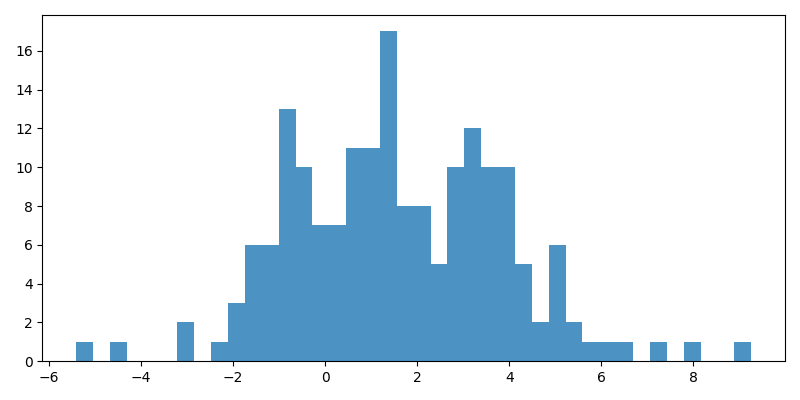

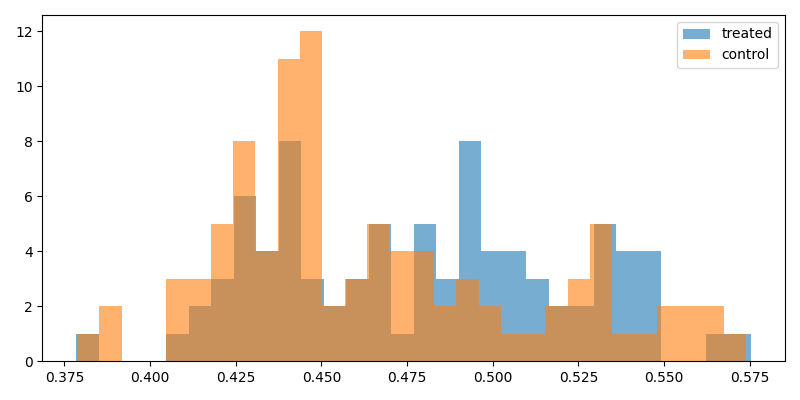

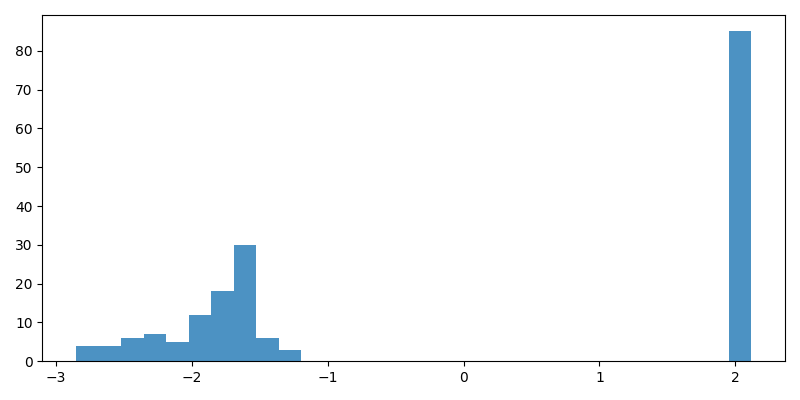

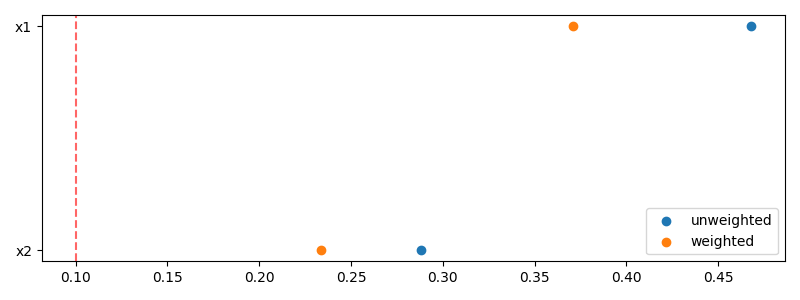

In [2]:
source_path = ROOT / 'examples' / 'out' / 'phase26_2_uc04_causal_dr_estimate' / 'dr.csv'
source_df = pd.read_csv(source_path)

config = {
    'config_version': 1,
    'task': {'type': 'regression'},
    'data': {'path': str(source_path), 'target': 'outcome'},
    'split': {'type': 'kfold', 'n_splits': 3, 'seed': 42},
    'train': {
        'seed': 42,
        'num_boost_round': 2000,
        'early_stopping_rounds': 200,
        'early_stopping_validation_fraction': 0.2,
        'auto_num_leaves': True,
        'num_leaves_ratio': 1.0,
        'min_data_in_leaf_ratio': 0.01,
        'min_data_in_bin_ratio': 0.01,
        'metrics': ['rmse', 'mae'],
        'lgb_params': {
            'learning_rate': 0.01,
            'max_bin': 255,
            'max_depth': 10,
            'feature_fraction': 1.0,
            'bagging_fraction': 1.0,
            'bagging_freq': 0,
            'lambda_l1': 0.0,
            'lambda_l2': 0.000001,
            'min_child_samples': 20,
            'first_metric_only': True,
        },
    },
    'causal': {
        'method': 'dr',
        'treatment_col': 'treatment',
        'estimand': 'att',
    },
    'export': {'artifact_dir': str(OUT_DIR / 'artifacts')},
}

result = estimate_dr(config)
obs_df = pd.read_parquet(result.metadata['observation_path'])
dr_table = build_dr_table(obs_df)
dt_path = OUT_DIR / 'dr_table.csv'
dr_table.to_csv(dt_path, index=False)

if_path = diag_dir / 'if_distribution.png'
plot_if_distribution(obs_df['psi'].to_numpy(dtype=float), if_path)
prop_path = diag_dir / 'propensity_distribution.png'
plot_propensity_distribution(
    obs_df['e_hat'].to_numpy(dtype=float),
    obs_df['treatment'].to_numpy(dtype=int),
    prop_path,
)
weight_path = diag_dir / 'weight_distribution.png'
plot_weight_distribution(obs_df['weight'].to_numpy(dtype=float), weight_path)

covariates = source_df[['x1', 'x2']].reset_index(drop=True)
smd_unweighted = compute_balance_smd(covariates, obs_df['treatment'])
smd_weighted = compute_balance_smd(covariates, obs_df['treatment'], obs_df['weight'])
love_path = diag_dir / 'love_plot.png'
plot_love_plot(smd_unweighted, smd_weighted, love_path)

overlap_stats = compute_overlap_stats(
    obs_df['e_hat'].to_numpy(dtype=float),
    obs_df['treatment'].to_numpy(dtype=int),
)
metrics_df = pd.DataFrame(
    [
        {
            'label': 'dr_att',
            'estimate': result.estimate,
            'std_error': result.std_error,
            'ci_lower': result.ci_lower,
            'ci_upper': result.ci_upper,
            'overlap_metric': result.metrics.get('overlap_metric'),
            'smd_max_unweighted': result.metrics.get('smd_max_unweighted'),
            'smd_max_weighted': result.metrics.get('smd_max_weighted'),
            **overlap_stats,
        }
    ]
)
metrics_path = OUT_DIR / 'metrics.csv'
metrics_df.to_csv(metrics_path, index=False)
smd_path = OUT_DIR / 'balance_smd.csv'
smd_unweighted.merge(
    smd_weighted,
    on='feature',
    suffixes=('_unweighted', '_weighted'),
    how='outer',
).to_csv(smd_path, index=False)

display(metrics_df)
display(dr_table.head(10))
display(pd.read_csv(smd_path))
display(Image(filename=str(if_path)))
display(Image(filename=str(prop_path)))
display(Image(filename=str(weight_path)))
display(Image(filename=str(love_path)))

summary_outputs = [
    metrics_path,
    dt_path,
    smd_path,
    if_path,
    prop_path,
    weight_path,
    love_path,
]
artifact_path_for_summary = Path(result.metadata['summary_path']).parent


## Result Summary

In [3]:
SUMMARY = {
    "uc": UC_ID,
    "executed_at_utc": datetime.now(timezone.utc).isoformat(),
    "status": "passed",
    "artifact_path": str(artifact_path_for_summary),
    "outputs": [str(p) for p in summary_outputs],
    "metrics": metrics_df.round(6).to_dict(orient="records"),
}
(OUT_DIR / "summary.json").write_text(json.dumps(SUMMARY, indent=2), encoding="utf-8")
SUMMARY


{'uc': 'UC-4',
 'executed_at_utc': '2026-02-19T16:08:52.258266+00:00',
 'status': 'passed',
 'artifact_path': '/home/rem/repos/VeldraML/examples/out/phase26_2_uc04_causal_dr_estimate/artifacts/causal/662eec90bd1b4abc98799267184501d8',
 'outputs': ['/home/rem/repos/VeldraML/examples/out/phase26_2_uc04_causal_dr_estimate/metrics.csv',
  '/home/rem/repos/VeldraML/examples/out/phase26_2_uc04_causal_dr_estimate/dr_table.csv',
  '/home/rem/repos/VeldraML/examples/out/phase26_2_uc04_causal_dr_estimate/balance_smd.csv',
  '/home/rem/repos/VeldraML/examples/out/phase26_2_uc04_causal_dr_estimate/diagnostics/if_distribution.png',
  '/home/rem/repos/VeldraML/examples/out/phase26_2_uc04_causal_dr_estimate/diagnostics/propensity_distribution.png',
  '/home/rem/repos/VeldraML/examples/out/phase26_2_uc04_causal_dr_estimate/diagnostics/weight_distribution.png',
  '/home/rem/repos/VeldraML/examples/out/phase26_2_uc04_causal_dr_estimate/diagnostics/love_plot.png'],
 'metrics': [{'label': 'dr_att',
   'es